# Table of contents
1. [Notebook Setup](#setup)
2. [Dataset Information](#data)
3. [Build Features](#build-features)
    1. [Collect Features](#collect)
4. [Exploratory Data Analysis](#explore)
5. [Build Pipeline](#pipeline)
6. [Parameter Tuning](#tuning)
    1. [Model Selection](#select)
        1. [Parameter Search](#param)
        2. [Model Search](#model)
    2. [Selected Model Tuning](#final-tune)

# Notebook Setup <a name="setup"></a>

In [775]:
#import sys
#!{sys.executable} -m pip install pandasql

In [776]:
# import standard packages
import numpy as np
import pandas as pd
import random

# for working with data frames/SQL
from pandas import DataFrame 
from pandasql import sqldf

# for converting dates to python readable date format
from datetime import datetime

# visualization packages
import matplotlib.pyplot as plt
import seaborn as sns


# scikit-learn modules:

# preprocessing
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, PowerTransformer, MaxAbsScaler, KBinsDiscretizer, PowerTransformer, QuantileTransformer, RobustScaler
from sklearn.feature_selection import VarianceThreshold, SelectFpr, chi2, f_classif
from sklearn.impute import SimpleImputer

# model training/tuning
from sklearn.pipeline import Pipeline, make_pipeline 
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.dummy import DummyClassifier
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector


# models
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# model validation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score, accuracy_score, make_scorer


# dataframe viewing rows
#pd.set_option('display.max_rows', 100)

# Dataset Information <a name="data"></a>

To run this notebook on your own computer, download the formula1_data folder from the google drive and fix the file path names in the cell below to match the file location on your computer.

In [777]:
#f1 data from kaggle
circuits = pd.read_csv('/Users/addieduncan/Desktop/formula1_data/circuits.csv')
constructor_results = pd.read_csv('/Users/addieduncan/Desktop/formula1_data/constructor_results.csv')
constructor_standings = pd.read_csv('/Users/addieduncan/Desktop/formula1_data/constructor_standings.csv')
constructors = pd.read_csv('/Users/addieduncan/Desktop/formula1_data/constructors.csv')
driver_standings = pd.read_csv('/Users/addieduncan/Desktop/formula1_data/driver_standings.csv')
drivers = pd.read_csv('/Users/addieduncan/Desktop/formula1_data/drivers.csv')
lap_times = pd.read_csv('/Users/addieduncan/Desktop/formula1_data/lap_times.csv')
pit_stops = pd.read_csv('/Users/addieduncan/Desktop/formula1_data/pit_stops.csv')
qualifying = pd.read_csv('/Users/addieduncan/Desktop/formula1_data/qualifying.csv')
races = pd.read_csv('/Users/addieduncan/Desktop/formula1_data/races.csv')
results = pd.read_csv('/Users/addieduncan/Desktop/formula1_data/results.csv')
seasons = pd.read_csv('/Users/addieduncan/Desktop/formula1_data/seasons.csv')
sprint_results = pd.read_csv('/Users/addieduncan/Desktop/formula1_data/sprint_results.csv')
status = pd.read_csv('/Users/addieduncan/Desktop/formula1_data/status.csv')


#data from elsewhere
countries = pd.read_csv('/Users/addieduncan/Desktop/formula1_data/countries.csv')

## Join keys for each table:

circuits - circuitId

constructor_results - constructorResultsId, raceId, constructorId, status 

constructor_standings - constructorStandingId, raceId, constructorId

constructors - constructorId

driver_standings - driverStandingsId, raceId, driverId

drivers - driverId

lap_times - raceId, driverId

pit_stops - race_id, driverId

qualifying - qualifyId, raceId, driverId, constructorId

races - raceId, circuitId, year

results - resultID, raceId, driverId, constructorId, statusId

seasons - year

sprint_results - resultId, raceId, driverId, constructorId, statusId

status - statusId

## Task: Predict race winner.

### features:
driver home race - DONE

driver age - DONE

number of past races for driver - DONE

number of past races driver has with constructor - DONE

number of past races for constructor - DONE

constructor home race - DONE

start grid position - DONE

grid changes post qualifying - DONE

Driver DNF ratio - DONE

constructor DNF ratio - DONE

round of season - DONE

driver standing - DONE

constructor standing - DONE

number of wins this season driver - DONE

number of wins this season constructor - DONE

position in last race - DONE


### Other features to possibly add later (requires webscrape):
number of laps

day or night

street or track

weather

# Build Features <a name="build-features"></a>

In [778]:
# fix countried data frame to use for joining
# create a new data frame that splits the entries in the nationality column by ','
country_nationalities = countries['nationality'].str.split(pat = ',', expand=True)
countries[['nationality1','nationality2','nationality3','nationality4']] = country_nationalities

#replace names to match our f1 data set names
countries = countries.replace(to_replace='Russian Federation', value='Russia')
countries = countries.replace(to_replace='United Kingdom of Great Britain and Northern Ireland', value='UK')
countries = countries.replace(to_replace='United Arab Emirates', value='UAE')
countries = countries.replace(to_replace="Korea (Democratic People's Republic of)", value='Korea')
countries = countries.replace(to_replace="United States of America", value='USA')
circuits = circuits.replace(to_replace="United States", value='USA')

In [779]:
# join countries to get nationality associated with each circuit
race_place = sqldf("""SELECT circuits.circuitId, circuits.country, countries.en_short_name, countries.nationality1
FROM circuits
INNER JOIN countries
ON circuits.country = countries.en_short_name""", env=None)

In [780]:
# Join drivers to race_place on shared nationality
home_race = sqldf("""SELECT race_place.circuitId, race_place.nationality1, drivers.driverId, drivers.nationality 
FROM drivers
LEFT JOIN race_place
ON drivers.nationality = race_place.nationality1""", env=None)

# add a new column to indicate that the pair shares a nationality 
# (it will be all 1's for now but when we join to our other features the 
#    non-matching driver/circuit pairs will get a null values)
home_race['home_race_indicator'] = 1

display(home_race)

,circuitId,nationality1,driverId,nationality,home_race_indicator
0,9.0,British,1,British,1
1,31.0,British,1,British,1
2,38.0,British,1,British,1
3,58.0,British,1,British,1
4,10.0,German,2,German,1
...,...,...,...,...,...
4209,60.0,American,858,American,1
4210,63.0,American,858,American,1
4211,69.0,American,858,American,1
4212,79.0,American,858,American,1


In [781]:
# Join constructors to race_place on shared nationality
home_race_con = sqldf("""SELECT race_place.circuitId, race_place.nationality1, constructors.constructorId, constructors.nationality 
FROM constructors
LEFT JOIN race_place
ON constructors.nationality = race_place.nationality1""", env=None)

# add a new column to indicate that the pair shares a nationality 
# (it will be all 1's for now but when we join to our other features the 
#    non-matching driver/circuit pairs will get a null values)
home_race_con['home_race_con_indicator'] = 1

display(home_race_con)

,circuitId,nationality1,constructorId,nationality,home_race_con_indicator
0,9.0,British,1,British,1
1,31.0,British,1,British,1
2,38.0,British,1,British,1
3,58.0,British,1,British,1
4,10.0,German,2,German,1
...,...,...,...,...,...
1105,41.0,French,214,French,1
1106,51.0,French,214,French,1
1107,53.0,French,214,French,1
1108,54.0,French,214,French,1


In [782]:
# make function to determine age given birthdate and any date
def age_at_race(born, race_date): 
    born = datetime.strptime(born, "%Y-%m-%d").date() 
    race_date = datetime.strptime(race_date, "%Y-%m-%d").date()
    return race_date.year - born.year - ((race_date.month,  
                                      race_date.day) < (born.month,  
                                                    born.day)) 

In [783]:
# join drivers and races
race_age = sqldf("""SELECT drivers.driverId, races.raceId, drivers.dob, races.date 
FROM drivers
INNER JOIN results
ON drivers.driverId = results.driverId
INNER JOIN races
ON results.raceID = races.raceId""", env=None)

# get age of driver at the date of race
race_age['age'] = race_age.apply(lambda x: age_at_race(x['dob'], x['date']),axis=1)

display(race_age)

,driverId,raceId,dob,date,age
0,1,1,1985-01-07,2009-03-29,24
1,1,2,1985-01-07,2009-04-05,24
2,1,3,1985-01-07,2009-04-19,24
3,1,4,1985-01-07,2009-04-26,24
4,1,5,1985-01-07,2009-05-10,24
...,...,...,...,...,...
26075,858,1106,2000-12-31,2023-06-18,22
26076,858,1107,2000-12-31,2023-07-02,22
26077,858,1108,2000-12-31,2023-07-09,22
26078,858,1109,2000-12-31,2023-07-23,22


In [784]:
# order races by date
race_history = sqldf("""SELECT results.resultId, races.raceId, results.driverId, results.constructorId, races.date
FROM results
INNER JOIN races
ON results.raceID = races.raceId
WHERE results.grid != 0
ORDER BY races.date""", env=None)

# count number of races driver has prior to race
race_history['driver_race_count'] = race_history.groupby('driverId')['raceId'].cumcount()

# count number of races driver has with constructor
race_history['driver_con_count'] = race_history.groupby(['driverId','constructorId'])['raceId'].cumcount()

# count number of races constructor has prior to race
race_history['con_race_count'] = race_history.groupby('constructorId')['raceId'].cumcount()


display(race_history)

,resultId,raceId,driverId,constructorId,date,driver_race_count,driver_con_count,con_race_count
0,20025,833,642,51,1950-05-13,0,0,0
1,20026,833,786,51,1950-05-13,0,0,1
2,20027,833,686,51,1950-05-13,0,0,2
3,20028,833,704,154,1950-05-13,0,0,0
4,20029,833,627,154,1950-05-13,0,0,1
...,...,...,...,...,...,...,...,...
24459,26080,1110,825,210,2023-07-30,150,109,303
24460,26081,1110,817,213,2023-07-30,232,1,137
24461,26082,1110,858,3,2023-07-30,11,11,1586
24462,26084,1110,832,6,2023-07-30,173,55,2350


In [785]:
# join qualifying results and final grid position for race
start_position = sqldf("""SELECT results.resultId, results.raceId, results.driverId, results.grid, qualifying.position, races.year
FROM results
LEFT JOIN qualifying
ON results.raceID = qualifying.raceId AND results.driverId = qualifying.driverId
INNER JOIN races
ON results.raceID = races.raceId
WHERE races.year >= 2003 AND results.grid != 0
ORDER BY qualifying.position""", env=None)


# calculate grid position movement from qualifying grid to final grid position for race
start_position['grid_delta'] = start_position['grid'] - start_position['position']
start_position = start_position.fillna(0)

display(start_position)
#print(start_position.to_string())

,resultId,raceId,driverId,grid,position,year,grid_delta
0,20858,844,155,24,0.0,2011,0.0
1,20880,845,2,24,0.0,2011,0.0
2,21044,852,30,24,0.0,2011,0.0
3,21195,858,22,24,0.0,2011,0.0
4,21362,865,815,23,0.0,2012,0.0
...,...,...,...,...,...,...,...
8222,21588,874,39,24,24.0,2012,0.0
8223,21634,876,819,24,24.0,2012,0.0
8224,21661,877,39,23,24.0,2012,-1.0
8225,21685,878,39,24,24.0,2012,0.0


In [786]:
# find all DNFs
DNF = sqldf("""SELECT 
results.resultId, 
status.status
FROM results
INNER JOIN status
ON results.statusId = status.statusId
WHERE status.status != 'Finished' AND status.status NOT LIKE '%lap%'""", env=None)

# fill indicator with 1
DNF['DNF'] = 1

# join DNF indicator with data
DNF_ratio = sqldf("""SELECT results.resultId, results.driverId,results.constructorId,DNF.DNF
FROM results
LEFT JOIN DNF
ON results.resultId = DNF.resultId
INNER JOIN races
ON results.raceId = races.raceId
ORDER BY races.date""", env=None)

# Fill null
DNF_ratio = DNF_ratio.fillna(0)

# calculate cumulative DNF average for driver and for constructor
DNF_ratio['cum_DNF_ratio'] = DNF_ratio.groupby('driverId')['DNF'].expanding().mean().reset_index(level=0, drop=True)
DNF_ratio['cum_con_DNF_ratio'] = DNF_ratio.groupby('constructorId')['DNF'].expanding().mean().reset_index(level=0, drop=True)

display(DNF_ratio)

,resultId,driverId,constructorId,DNF,cum_DNF_ratio,cum_con_DNF_ratio
0,20025,642,51,0.0,0.000000,0.000000
1,20026,786,51,0.0,0.000000,0.000000
2,20027,686,51,0.0,0.000000,0.000000
3,20028,704,154,0.0,0.000000,0.000000
4,20029,627,154,0.0,0.000000,0.000000
...,...,...,...,...,...,...
26075,26081,817,213,0.0,0.162393,0.164384
26076,26082,858,3,0.0,0.250000,0.306401
26077,26083,807,210,0.0,0.219388,0.217949
26078,26084,832,6,1.0,0.200000,0.307465


In [787]:
# find driver rank at each race
driver_rank = sqldf("""SELECT results.raceId, results.driverId, driver_standings.position, driver_standings.wins
FROM results
INNER JOIN races
ON results.raceId = races.raceId
LEFT JOIN driver_standings
ON races.raceId = driver_standings.raceId AND results.driverId = driver_standings.driverId
ORDER BY races.date""", env=None)

# offset to get rank before race
driver_rank['standing'] = driver_rank.groupby('driverId')['position'].shift(1).bfill(axis=0)

display(driver_rank)

,raceId,driverId,position,wins,standing
0,833,642,1.0,1.0,13.0
1,833,786,2.0,0.0,13.0
2,833,686,3.0,0.0,13.0
3,833,704,4.0,0.0,13.0
4,833,627,5.0,0.0,13.0
...,...,...,...,...,...
26075,1110,817,21.0,0.0,21.0
26076,1110,858,19.0,0.0,19.0
26077,1110,807,14.0,0.0,14.0
26078,1110,832,7.0,0.0,6.0


In [788]:
# find constructor rank at each race
con_rank = sqldf("""SELECT results.raceId, results.constructorId, constructor_standings.position, constructor_standings.wins
FROM results
INNER JOIN races
ON results.raceId = races.raceId
LEFT JOIN constructor_standings
ON races.raceId = constructor_standings.raceId AND results.constructorId = constructor_standings.constructorId
ORDER BY races.date""", env=None)

con_rank = con_rank.drop_duplicates(subset=['raceId','constructorId'])

# offset to get rank before race
con_rank['con_standing'] = con_rank.groupby('constructorId')['position'].shift(1).bfill(axis=0)
con_rank['con_wins'] = con_rank['wins']


display(con_rank)

,raceId,constructorId,position,wins,con_standing,con_wins
0,833,51,NaN,NaN,1.0,NaN
3,833,154,NaN,NaN,1.0,NaN
5,833,151,NaN,NaN,1.0,NaN
8,833,105,NaN,NaN,1.0,NaN
12,833,126,NaN,NaN,1.0,NaN
...,...,...,...,...,...,...
26067,1110,214,6.0,0.0,6.0,0.0
26069,1110,213,10.0,0.0,10.0,0.0
26071,1110,51,9.0,0.0,9.0,0.0
26073,1110,3,7.0,0.0,7.0,0.0


In [789]:
# get race info in order by date
last_race = sqldf("""SELECT results.raceId, results.driverId, results.positionOrder
FROM results
INNER JOIN races
ON results.raceId = races.raceId
ORDER BY races.date""", env=None)

# find position in last race
last_race['last_race_finish'] = last_race.groupby(['driverId'])['positionOrder'].shift(1).bfill(axis=0)

## Collect Features and Label <a name="collect"></a>

In [790]:
# create table of join keys to use for feature table, use races from last 20 years, only races where driver actually started
key_table = sqldf("""SELECT results.resultId, races.raceId, drivers.driverId, constructors.constructorId, circuits.circuitId
FROM results
INNER JOIN races
ON results.raceID = races.raceId
INNER JOIN drivers
ON results.driverId = drivers.driverId
INNER JOIN constructors
ON results.constructorId = constructors.constructorId
INNER JOIN circuits
ON races.circuitId = circuits.circuitId
WHERE races.year >= 2003 AND results.grid != 0""", env=None)

# throw out duplicate entries where in the 50s and 60s drivers could switch cars mid-race
key_table = key_table.drop_duplicates(subset=['driverId','raceId'], keep=False)

display(key_table)

,resultId,raceId,driverId,constructorId,circuitId
0,1,18,1,1,1
1,2,18,2,2,1
2,3,18,3,3,1
3,4,18,4,4,1
4,5,18,5,1,1
...,...,...,...,...,...
8222,26080,1110,825,210,13
8223,26081,1110,817,213,13
8224,26082,1110,858,3,13
8225,26084,1110,832,6,13


In [791]:
# join all features in a table
features = sqldf("""SELECT 
key_table.resultId, 
key_table.raceId, 
key_table.driverId, 
key_table.constructorId, 
key_table.circuitId, 
results.positionOrder, 
home_race.home_race_indicator, 
home_race_con.home_race_con_indicator,
race_age.age,
race_history.driver_race_count,
race_history.driver_con_count,
race_history.con_race_count,
start_position.grid,
start_position.grid_delta,
races.round,
DNF_ratio.cum_DNF_ratio,
DNF_ratio.cum_con_DNF_ratio,
driver_rank.standing,
driver_rank.wins,
con_rank.con_standing,
con_rank.con_wins,
last_race.last_race_finish
FROM key_table
INNER JOIN results
ON key_table.resultId = results.resultId
LEFT JOIN home_race
ON key_table.driverId = home_race.driverId AND key_table.circuitId = home_race.circuitId
LEFT JOIN home_race_con
ON key_table.constructorId = home_race_con.constructorId AND key_table.circuitId = home_race_con.circuitId
INNER JOIN race_age
ON key_table.driverId = race_age.driverId AND key_table.raceId = race_age.raceId
INNER JOIN race_history
ON key_table.resultId = race_history.resultId
INNER JOIN start_position
ON key_table.resultId = start_position.resultId
INNER JOIN races
ON key_table.raceId = races.raceId
INNER JOIN DNF_ratio
ON key_table.resultId = DNF_ratio.resultId
INNER JOIN driver_rank
ON key_table.raceId = driver_rank.raceId AND key_table.driverId = driver_rank.driverId
INNER JOIN con_rank
ON key_table.raceId = con_rank.raceId AND key_table.constructorId = con_rank.constructorId
INNER JOIN last_race
ON key_table.driverId = last_race.driverId AND key_table.raceId = last_race.raceId""", env=None)

In [792]:
# fill in missing values with 0
features = features.fillna(0)

display(features)
#print(features.to_string())

# column check == 8227

,resultId,raceId,driverId,constructorId,circuitId,positionOrder,home_race_indicator,home_race_con_indicator,age,driver_race_count,...,grid,grid_delta,round,cum_DNF_ratio,cum_con_DNF_ratio,standing,wins,con_standing,con_wins,last_race_finish
0,1,18,1,1,1,1,0.0,0.0,23,17,...,1,0.0,1,0.055556,0.381833,2.0,1.0,11.0,1.0,7.0
1,2,18,2,2,1,2,0.0,0.0,30,133,...,5,0.0,1,0.320896,0.211268,5.0,0.0,2.0,0.0,6.0
2,3,18,3,3,1,3,0.0,0.0,22,35,...,7,0.0,1,0.361111,0.381764,9.0,0.0,4.0,0.0,4.0
3,4,18,4,4,1,4,0.0,0.0,26,105,...,11,-1.0,1,0.226415,0.441176,3.0,0.0,3.0,0.0,3.0
4,5,18,5,1,1,5,0.0,0.0,26,17,...,3,0.0,1,0.111111,0.381526,7.0,0.0,11.0,1.0,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8222,26080,1110,825,210,13,15,0.0,0.0,30,150,...,16,3.0,12,0.214286,0.218650,18.0,0.0,8.0,0.0,17.0
8223,26081,1110,817,213,13,16,0.0,0.0,34,232,...,19,0.0,12,0.162393,0.164384,21.0,0.0,10.0,0.0,13.0
8224,26082,1110,858,3,13,17,0.0,0.0,22,11,...,18,0.0,12,0.250000,0.306401,19.0,0.0,7.0,0.0,18.0
8225,26084,1110,832,6,13,19,0.0,0.0,28,173,...,4,-1.0,12,0.200000,0.307465,6.0,0.0,4.0,0.0,8.0


In [793]:
# create label column, 1 for win, 0 for not a win
label = sqldf("""SELECT features.resultId
FROM features
WHERE features.positionOrder == 1""", env=None)

label['label']=1

In [794]:
# join features and label to create data column
data = sqldf("""SELECT *
FROM features
LEFT JOIN label
ON features.resultId = label.resultId""", env=None)

data = data.fillna(0)

display(data)

,resultId,raceId,driverId,constructorId,circuitId,positionOrder,home_race_indicator,home_race_con_indicator,age,driver_race_count,...,round,cum_DNF_ratio,cum_con_DNF_ratio,standing,wins,con_standing,con_wins,last_race_finish,resultId,label
0,1,18,1,1,1,1,0.0,0.0,23,17,...,1,0.055556,0.381833,2.0,1.0,11.0,1.0,7.0,1.0,1.0
1,2,18,2,2,1,2,0.0,0.0,30,133,...,1,0.320896,0.211268,5.0,0.0,2.0,0.0,6.0,0.0,0.0
2,3,18,3,3,1,3,0.0,0.0,22,35,...,1,0.361111,0.381764,9.0,0.0,4.0,0.0,4.0,0.0,0.0
3,4,18,4,4,1,4,0.0,0.0,26,105,...,1,0.226415,0.441176,3.0,0.0,3.0,0.0,3.0,0.0,0.0
4,5,18,5,1,1,5,0.0,0.0,26,17,...,1,0.111111,0.381526,7.0,0.0,11.0,1.0,17.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8222,26080,1110,825,210,13,15,0.0,0.0,30,150,...,12,0.214286,0.218650,18.0,0.0,8.0,0.0,17.0,0.0,0.0
8223,26081,1110,817,213,13,16,0.0,0.0,34,232,...,12,0.162393,0.164384,21.0,0.0,10.0,0.0,13.0,0.0,0.0
8224,26082,1110,858,3,13,17,0.0,0.0,22,11,...,12,0.250000,0.306401,19.0,0.0,7.0,0.0,18.0,0.0,0.0
8225,26084,1110,832,6,13,19,0.0,0.0,28,173,...,12,0.200000,0.307465,6.0,0.0,4.0,0.0,8.0,0.0,0.0


# Exploratory Data Analysis <a name="explore"></a>

In [795]:
feature_list = ['home_race_indicator', # indicate if race is driver's home race
                'home_race_con_indicator', # indicate if race is constructors home race
                'age', # age of driver at date of race
                'driver_race_count', # number of races driver has particiapted in at time of race
                'driver_con_count', # number of races constructor has particiapte in at time of race
                'con_race_count', # number of races driver has had with current constructor
                'grid', # starting position for race (after penalties)
                #'grid_delta', # difference in starting position from qualifying finish
                #'round', # race number of season
                'cum_DNF_ratio', # driver career did not finish ratio at time of race
                'cum_con_DNF_ratio', # constructor career did not finish ratio at time of race
                'standing', # standing in driver championship at time of race
                'wins', # number of wins driver has had this season at time of race
                'con_standing',  # standing in constructor chamionship at time of race
                'con_wins', # number of wins constructor has had this season at time of race
                'last_race_finish'] # finishing position in previous race

num_features = ['age', # age of driver at date of race
                'driver_race_count', # number of races driver has particiapted in at time of race
                'driver_con_count', # number of races constructor has particiapte in at time of race
                'con_race_count', # number of races driver has had with current constructor
                'grid', # starting position for race (after penalties)
                #'grid_delta', # difference in starting position from qualifying finish
                #'round', # race number of season
                'cum_DNF_ratio', # driver career did not finish ratio at time of race
                'cum_con_DNF_ratio', # constructor career did not finish ratio at time of race
                'standing', # standing in driver championship at time of race
                'wins', # number of wins driver has had this season at time of race
                'con_standing',  # standing in constructor chamionship at time of race
                'con_wins', # number of wins constructor has had this season at time of race
                'last_race_finish'] # finishing position in previous race


cat_features = ['home_race_indicator', # indicate if race is driver's home race
                'home_race_con_indicator'] # indicate if race is constructors home race


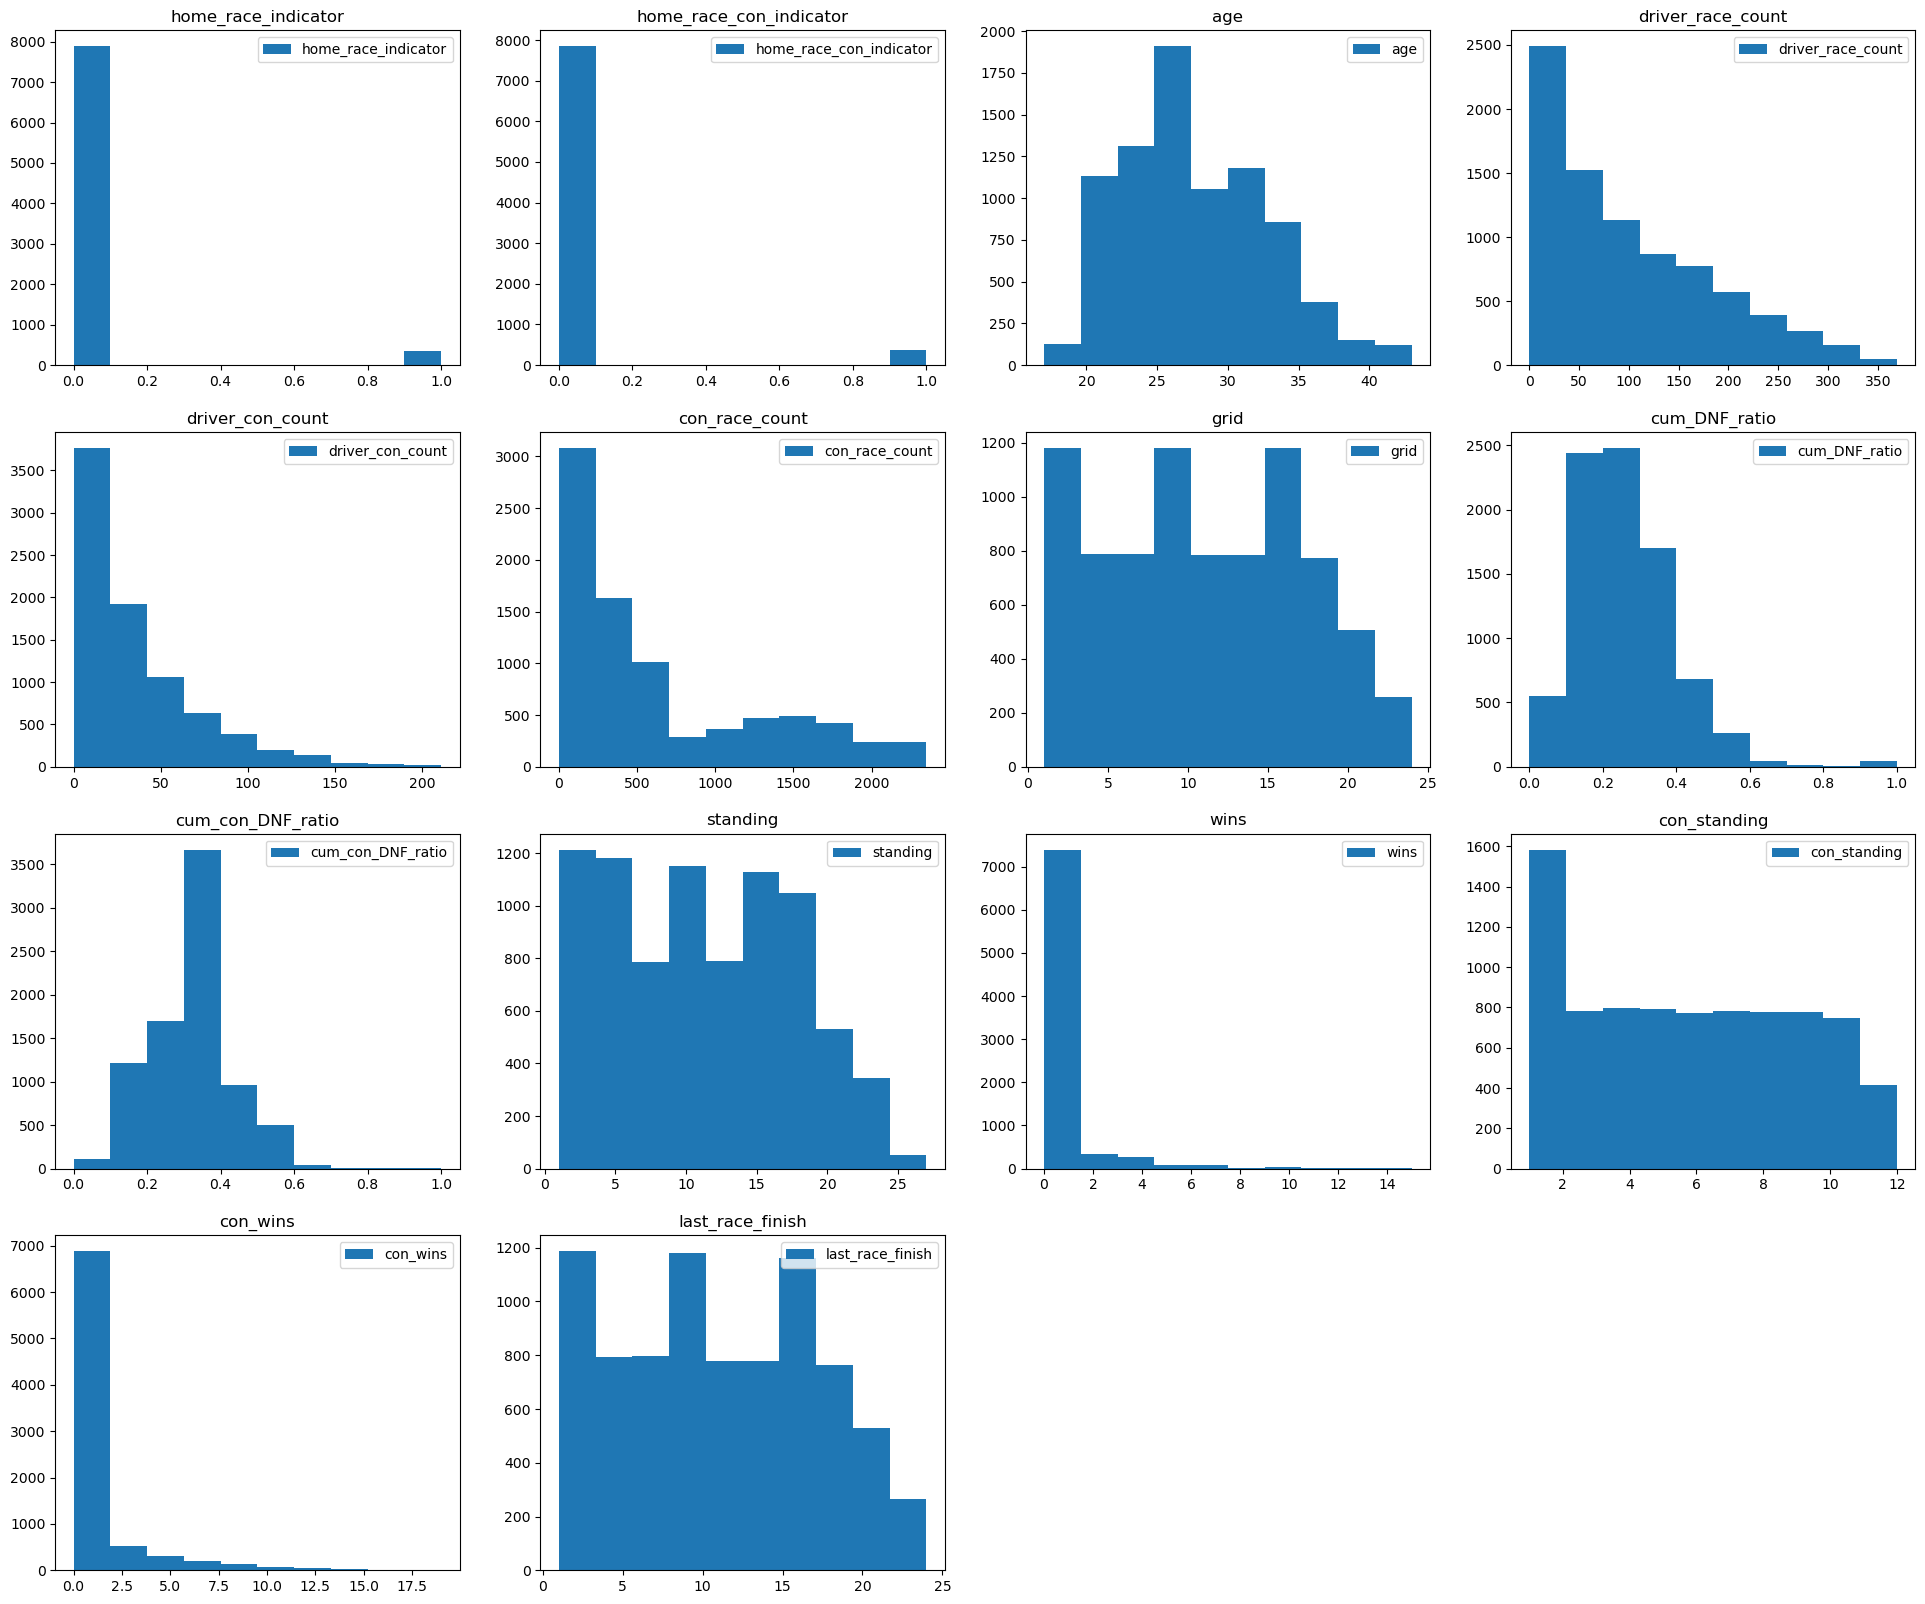

In [796]:
# define feature columns for plotting
feature_columns = data[feature_list]


# plot grid of feature histograms
plt.figure(figsize=(24,20))
for i, col in enumerate(feature_columns.columns.to_list()):
    plt.subplot(4, 4, i + 1)
    plt.hist(feature_columns[col], label=col)
    plt.legend()
    plt.title(col)
    #plt.tight_layout()

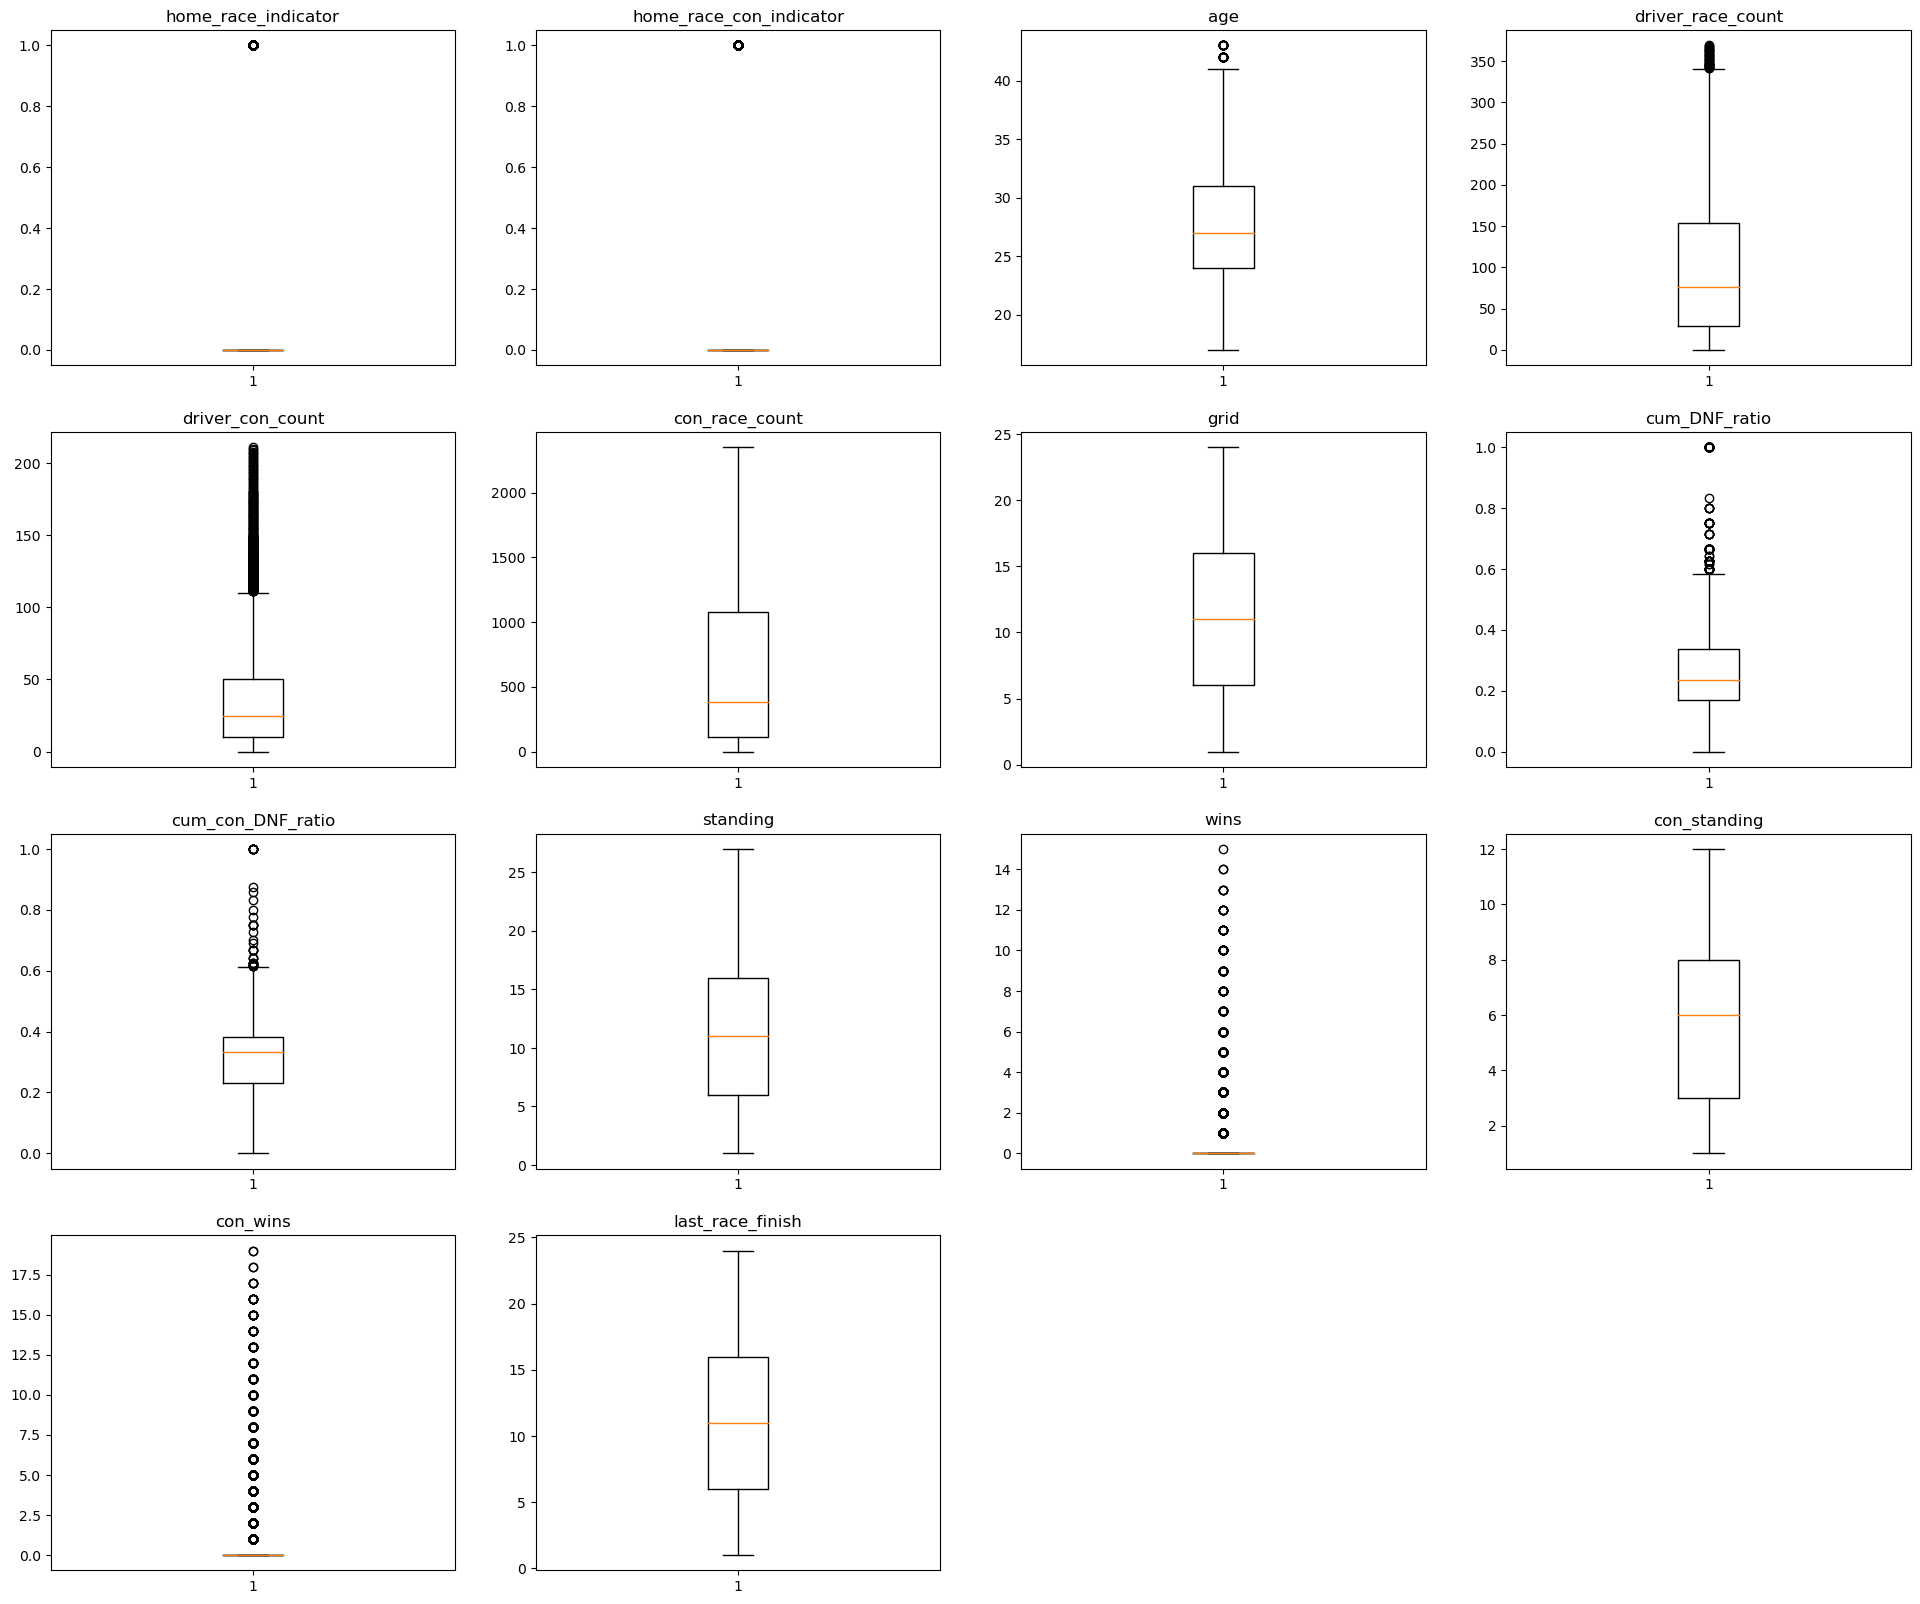

In [797]:
# plot grid of feature box plots to examine potential outliers
plt.figure(figsize=(24,20))
for i, col in enumerate(feature_columns.columns.to_list()):
    plt.subplot(4, 4, i + 1)
    plt.boxplot(feature_columns[col])
    plt.title(col)
    #plt.tight_layout()

Number of samples = 8227
Number of wins = 394


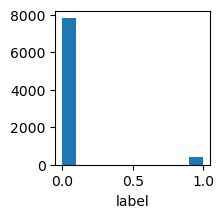

In [798]:
# plot label distribution
plt.figure(figsize=(2, 2))
plt.hist(data['label'])
plt.xlabel('label')

print('Number of samples = ' + str(data['label'].shape[0]))
print('Number of wins = ' + str(data['label'].loc[data['label'] == 1].shape[0]))

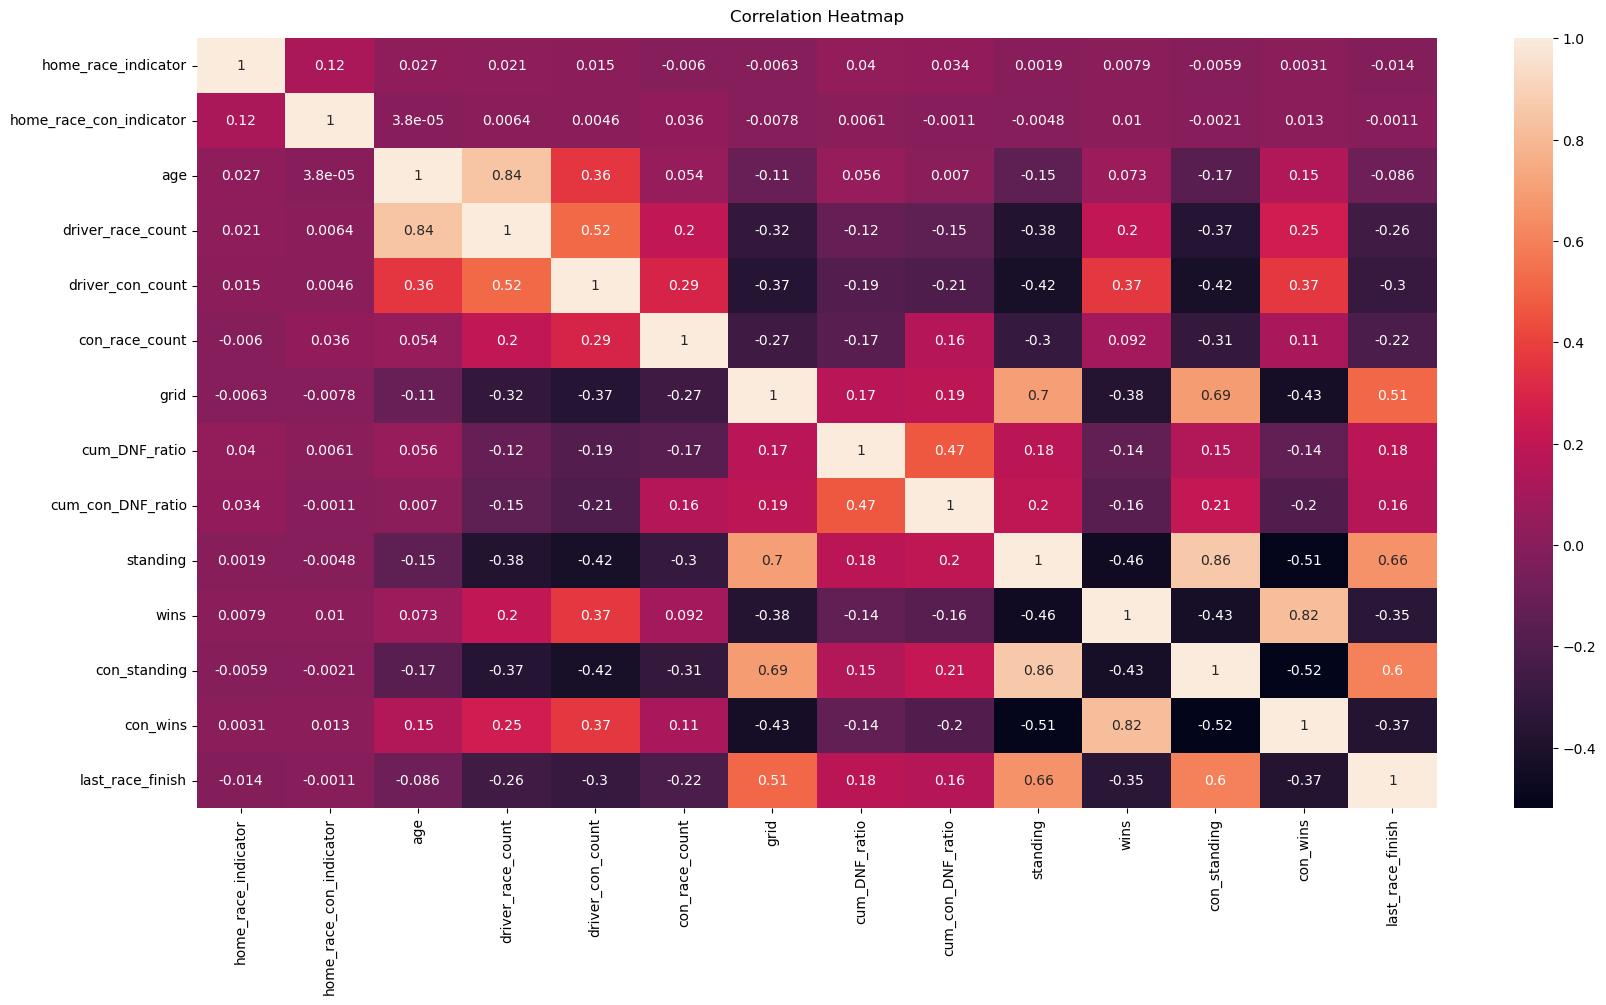

In [799]:
plt.figure(figsize=(20, 10))
heatmap = sns.heatmap(data[feature_list].corr(), annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

# Build Pipeline <a name="pipeline"></a>

In [800]:
# Use seed for reproducibility/validation!

# Set a Random State value
RANDOM_STATE = 3

# Set Python random a fixed value
import random
random.seed(RANDOM_STATE)

# Set numpy random a fixed value
import numpy as np
np.random.seed(RANDOM_STATE)

In [801]:
# define feature column data, list of features feature_list was created in the section above
X = data[feature_list] #.values


# define label column
y = data['label'] #.values


In [802]:
# make 75/25 train/test split, stratified because I have imbalanced label
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=RANDOM_STATE)

In [803]:
# check size of data splits
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5512, 14)
(2715, 14)
(5512,)
(2715,)


In [804]:
# Define scaler step of pipeline
scaler = Normalizer()

In [805]:
# Define machine learning models

# Logistic Regression:
lr = LogisticRegression(random_state=RANDOM_STATE)

# K-nearest Neighbors:
knn = KNeighborsClassifier(n_neighbors=10)

# Naive Bayes:
nb = GaussianNB()

# Random Forest:
rf = RandomForestClassifier(random_state=RANDOM_STATE)

# Gradient Boosted Trees:
gb = GradientBoostingClassifier(random_state=RANDOM_STATE)

In [806]:
# define function to get model metrics
def model_metrics(predictions, pipe):
    
    # print summary statistics
    print('Training set score: ' + str(pipe.score(X_train,y_train)))
    print('Test set score: ' + str(pipe.score(X_test,y_test)))
    print(classification_report(y_test, predictions, digits=5))

    # plot confusion matrix
    cm = confusion_matrix(y_test, predictions, normalize='all')
    print(cm)
    disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)
    disp_cm.plot()

In [807]:
# define workflow for training and printing model evaluation metrics
def train_and_evaluate(scaler,model_name):
    
    # make pipeline steps
    pipe = make_pipeline(scaler,model_name)

    # fit data to model
    pipe.fit(X_train, y_train)

    # save predictions on test set
    predictions = pipe.predict(X_test)

    # display results and metrics
    model_metrics(predictions, pipe)


Training set score: 1.0
Test set score: 0.9583793738489871
              precision    recall  f1-score   support

         0.0    0.96996   0.98685   0.97833      2585
         1.0    0.60000   0.39231   0.47442       130

    accuracy                        0.95838      2715
   macro avg    0.78498   0.68958   0.72638      2715
weighted avg    0.95225   0.95838   0.95420      2715

[[0.93959484 0.01252302]
 [0.02909761 0.01878453]]


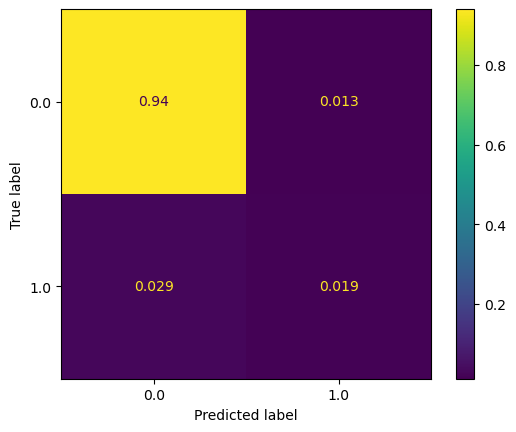

In [808]:
train_and_evaluate(scaler,rf)

training model:LogisticRegression(random_state=3)
Training set score: 0.9521044992743106
Test set score: 0.9521178637200737
              precision    recall  f1-score   support

         0.0    0.95212   1.00000   0.97547      2585
         1.0    0.00000   0.00000   0.00000       130

    accuracy                        0.95212      2715
   macro avg    0.47606   0.50000   0.48774      2715
weighted avg    0.90653   0.95212   0.92876      2715

[[0.95211786 0.        ]
 [0.04788214 0.        ]]
training model:KNeighborsClassifier(n_neighbors=10)


/Users/addieduncan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/addieduncan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/addieduncan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training set score: 0.9606313497822931
Test set score: 0.9569060773480663
              precision    recall  f1-score   support

         0.0    0.96183   0.99420   0.97774      2585
         1.0    0.65116   0.21538   0.32370       130

    accuracy                        0.95691      2715
   macro avg    0.80649   0.60479   0.65072      2715
weighted avg    0.94695   0.95691   0.94643      2715

[[0.946593   0.00552486]
 [0.03756906 0.01031308]]
training model:GaussianNB()
Training set score: 0.4856676342525399
Test set score: 0.48250460405156537
              precision    recall  f1-score   support

         0.0    0.99580   0.45841   0.62781      2585
         1.0    0.08197   0.96154   0.15106       130

    accuracy                        0.48250      2715
   macro avg    0.53888   0.70998   0.38944      2715
weighted avg    0.95204   0.48250   0.60499      2715

[[0.43646409 0.51565378]
 [0.00184162 0.04604052]]
training model:RandomForestClassifier(random_state=3)
Training set 

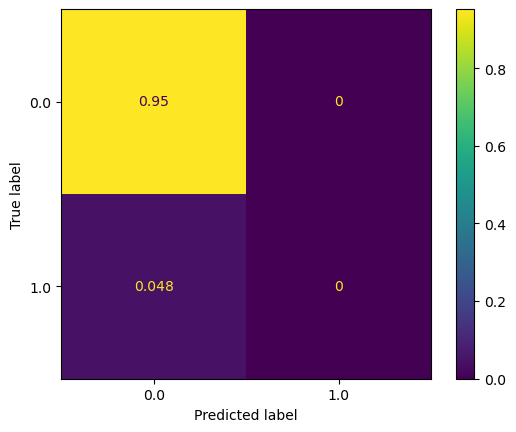

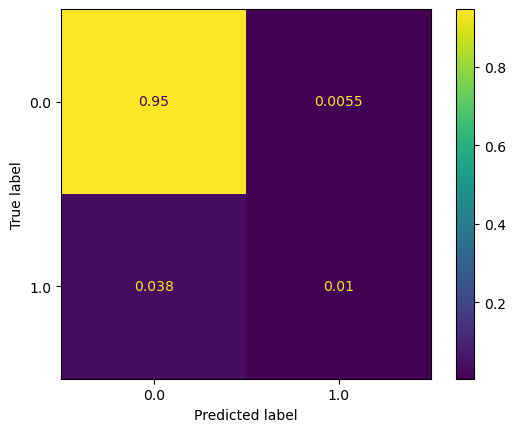

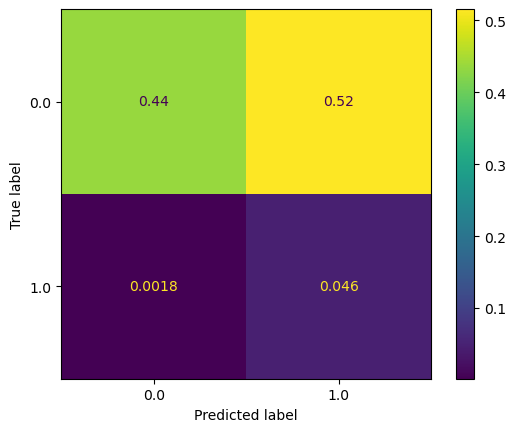

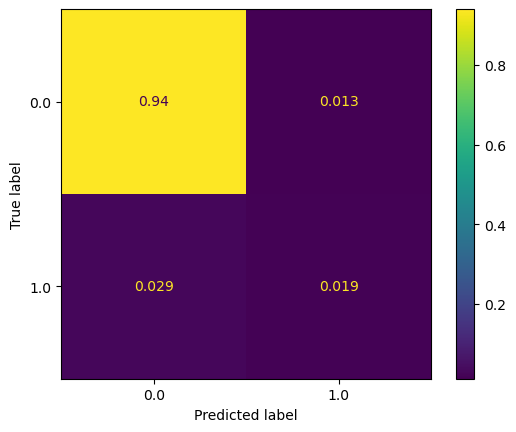

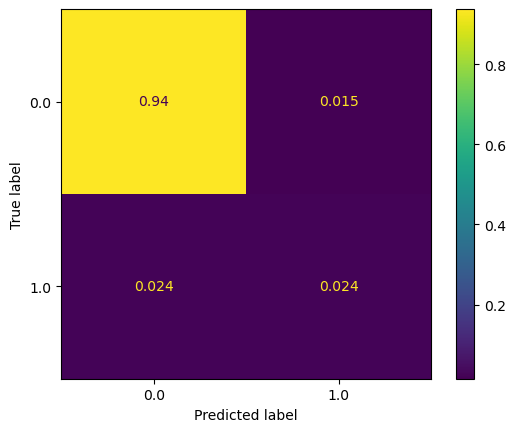

In [809]:
# create loop to test all models at once

model_names = [lr, knn, nb, rf, gb]
for name in model_names:
    print('training model:' + str(name))
    
    train_and_evaluate(scaler,name)

# Parameter Tuning <a name="tuning"></a>

In [810]:
# This is a function I pulled from 
# https://stackoverflow.com/questions/37161563/how-to-graph-grid-scores-from-gridsearchcv

# For each hyperparamter it fixes all other parameters to their best values 
# and plots the average score for each value of the hyperparamter.


def plot_search_results(grid):
    
    # Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']

    # Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    # Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()

## Model Selection <a name="select"></a>

We will use a cross-validation grid search to find a draft of optimal paramters for each model. Then we can use these parameters to search over for the best model.

### Parameter Search <a name="param"></a>

In [811]:
# define parameter search for each model

# Logistic Regression:
lr = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', max_iter=1000)

lr_param_grid = {'logisticregression__penalty': ['l1', 'l2'],
                 'logisticregression__C': [0.001, 0.01, 0.1, 1.0, 10, 25]
                }

# K-nearest Neighbors:
knn = KNeighborsClassifier(n_neighbors=10)

knn_param_grid = {'kneighborsclassifier__n_neighbors': [3, 5, 7, 9],
                  'kneighborsclassifier__weights': ['uniform', 'distance'],
                  'kneighborsclassifier__p': [1,2]
                 }

# Naive Bayes:
nb = GaussianNB()
# There are no meaningful paramters to tune for Naive Bayes model so we willl accept the default implementation.

# Random Forest:
rf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)

rf_param_grid = {'randomforestclassifier__n_estimators': [5, 10, 25, 50, 100],
                 'randomforestclassifier__criterion': ['gini', 'entropy', 'log_loss'],
                 'randomforestclassifier__max_depth': [3, 5, 10, 16],
                 'randomforestclassifier__max_features': ['sqrt', 'log2', 16],
                 'randomforestclassifier__max_samples': [0.25, 0.5, 0.75, 1]
                }

# Gradient Boosted Trees:
gb = GradientBoostingClassifier(random_state=RANDOM_STATE)

gb_param_grid = {'gradientboostingclassifier__n_estimators': [10, 25, 50, 100],
                 'gradientboostingclassifier__loss': ['log_loss', 'exponential'],
                 'gradientboostingclassifier__learning_rate': [0.01, 0.1, 0.5, 1],
                 'gradientboostingclassifier__subsample': [0.1, 0.5, 0.75, 1],
                 'gradientboostingclassifier__max_depth': [3, 5, 10, 16],
                 'gradientboostingclassifier__max_features': ['sqrt', 'log2', 16],
                }



In [812]:
# define workflow to perform grid search on a model 
#  and print the summary statistics for the best parameters 
#   and plot the results of the cross validation.
def search_train_evaluate_plot(model_name, param_grid, scorer):
    
    # define pipeline
    pipe = make_pipeline(scaler,model_name)

    # define parameter search
    grid_search = GridSearchCV(pipe, param_grid, cv=4, refit = True, verbose = 1, return_train_score=True, scoring=scorer, n_jobs=-1) 

    # train the model on grid search 
    grid_search.fit(X_train, y_train) 

    # print best parameters after tuning 
    print(grid_search.best_params_) 
    best_predictions = grid_search.predict(X_test) 

    # print summary of metrics for best parameters
    model_metrics(best_predictions, grid_search)
    
    # plot results of grid search
    plot_search_results(grid_search)

Fitting 4 folds for each of 12 candidates, totalling 48 fits
{'logisticregression__C': 10, 'logisticregression__penalty': 'l2'}
Training set score: 0.9626269956458636
Test set score: 0.965377532228361
              precision    recall  f1-score   support

         0.0    0.97339   0.99072   0.98198      2585
         1.0    0.71429   0.46154   0.56075       130

    accuracy                        0.96538      2715
   macro avg    0.84384   0.72613   0.77136      2715
weighted avg    0.96099   0.96538   0.96181      2715

[[0.94327808 0.00883978]
 [0.02578269 0.02209945]]


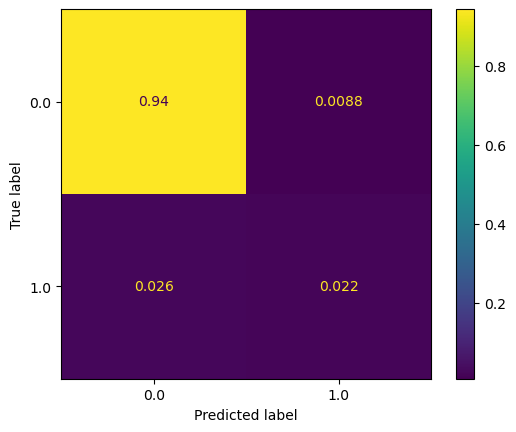

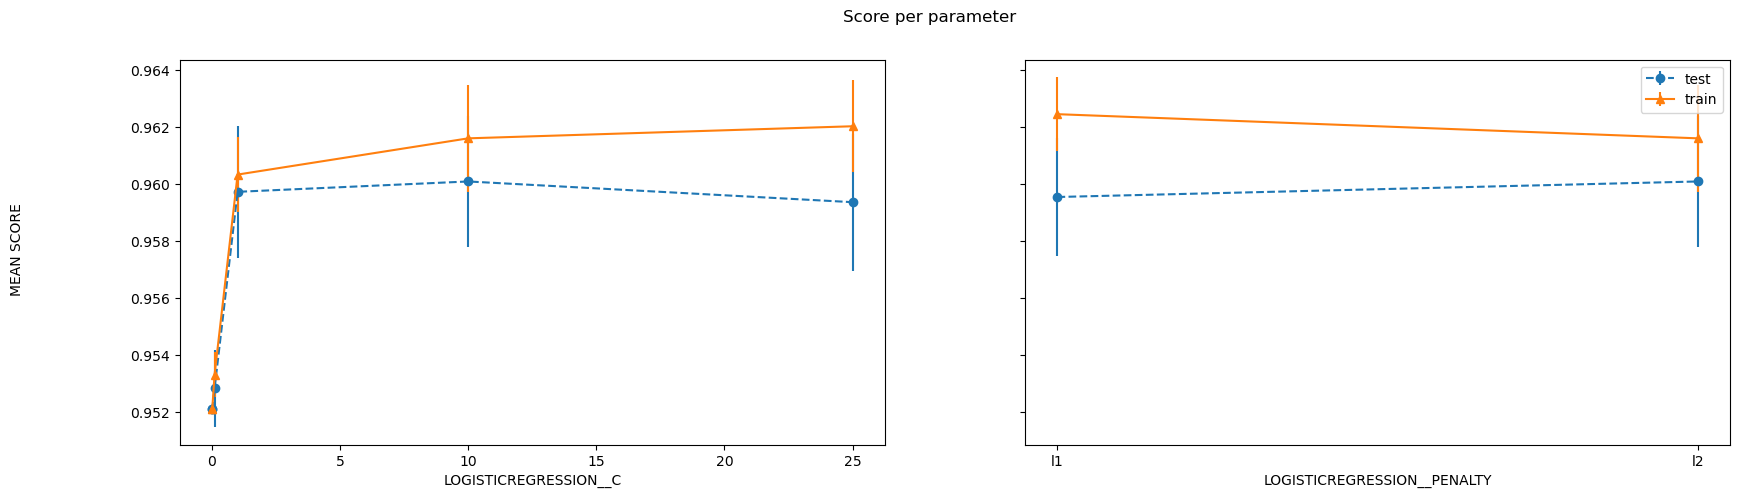

In [945]:
# define names for model
model_name = lr
param_grid = lr_param_grid
scorer = make_scorer(accuracy_score)
#scorer = make_scorer(recall_score)

# run model workflow
search_train_evaluate_plot(model_name, param_grid, scorer)

training model:LogisticRegression(max_iter=1000, random_state=3, solver='liblinear')
Fitting 4 folds for each of 12 candidates, totalling 48 fits
{'logisticregression__C': 25, 'logisticregression__penalty': 'l1'}
Training set score: 0.9599056603773585
Test set score: 0.9620626151012891
              precision    recall  f1-score   support

         0.0    0.96866   0.99226   0.98032      2585
         1.0    0.70149   0.36154   0.47716       130

    accuracy                        0.96206      2715
   macro avg    0.83507   0.67690   0.72874      2715
weighted avg    0.95586   0.96206   0.95622      2715

[[0.94475138 0.00736648]
 [0.0305709  0.01731123]]


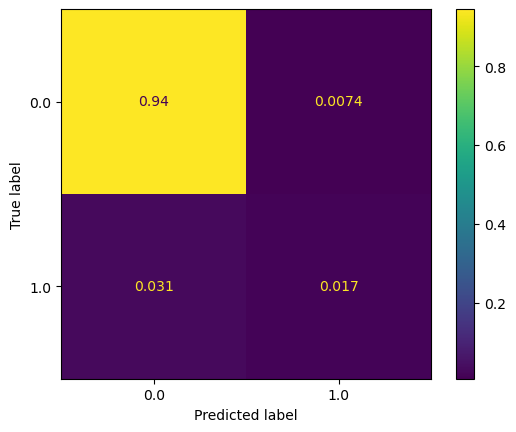

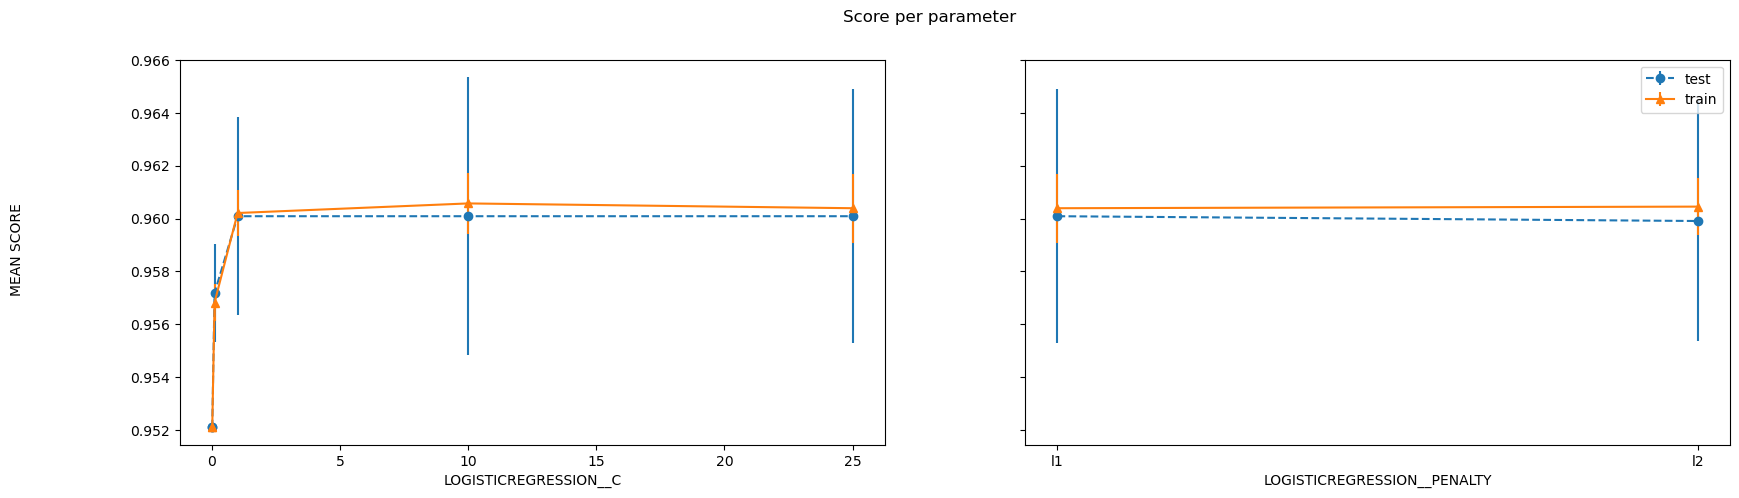

training model:KNeighborsClassifier(n_neighbors=10)
Fitting 4 folds for each of 16 candidates, totalling 64 fits
{'kneighborsclassifier__n_neighbors': 7, 'kneighborsclassifier__p': 1, 'kneighborsclassifier__weights': 'distance'}
Training set score: 1.0
Test set score: 0.9532228360957643
              precision    recall  f1-score   support

         0.0    0.96412   0.98762   0.97573      2585
         1.0    0.52239   0.26923   0.35533       130

    accuracy                        0.95322      2715
   macro avg    0.74326   0.62843   0.66553      2715
weighted avg    0.94297   0.95322   0.94602      2715

[[0.94033149 0.01178637]
 [0.03499079 0.01289134]]


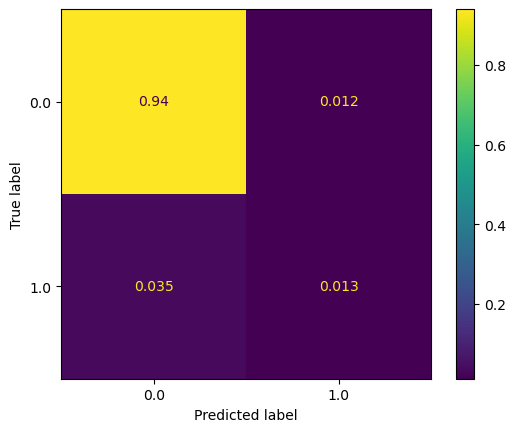

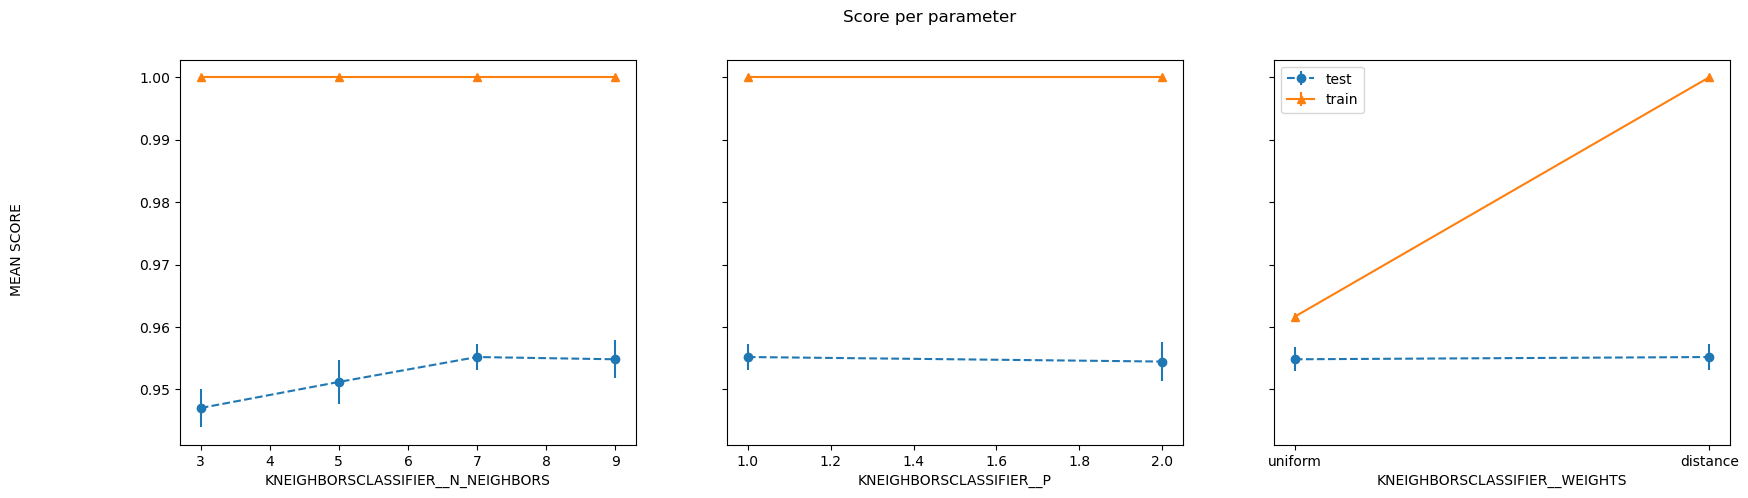

training model:GaussianNB()
Training set score: 0.8857039187227866
Test set score: 0.8832412523020258
              precision    recall  f1-score   support

         0.0    0.98837   0.88781   0.93540      2585
         1.0    0.26209   0.79231   0.39388       130

    accuracy                        0.88324      2715
   macro avg    0.62523   0.84006   0.66464      2715
weighted avg    0.95360   0.88324   0.90947      2715

[[0.84530387 0.106814  ]
 [0.00994475 0.03793738]]
training model:RandomForestClassifier(n_jobs=-1, random_state=3)
Fitting 4 folds for each of 720 candidates, totalling 2880 fits
{'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 16, 'randomforestclassifier__max_features': 16, 'randomforestclassifier__max_samples': 0.25, 'randomforestclassifier__n_estimators': 100}
Training set score: 0.9807692307692307
Test set score: 0.9679558011049724
              precision    recall  f1-score   support

         0.0    0.97635   0.99033   0.

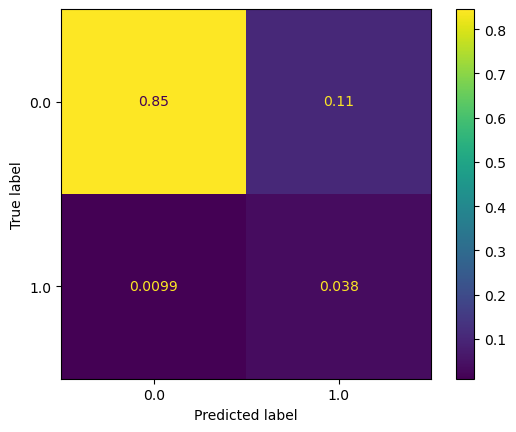

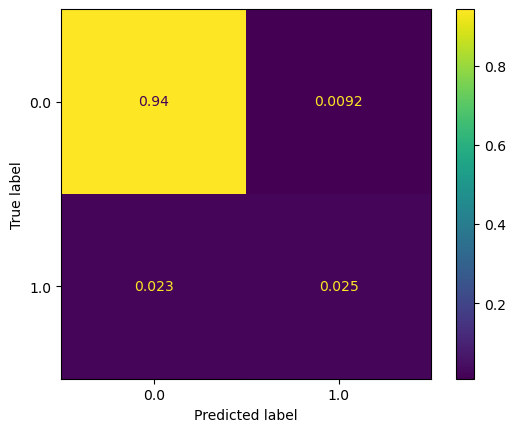

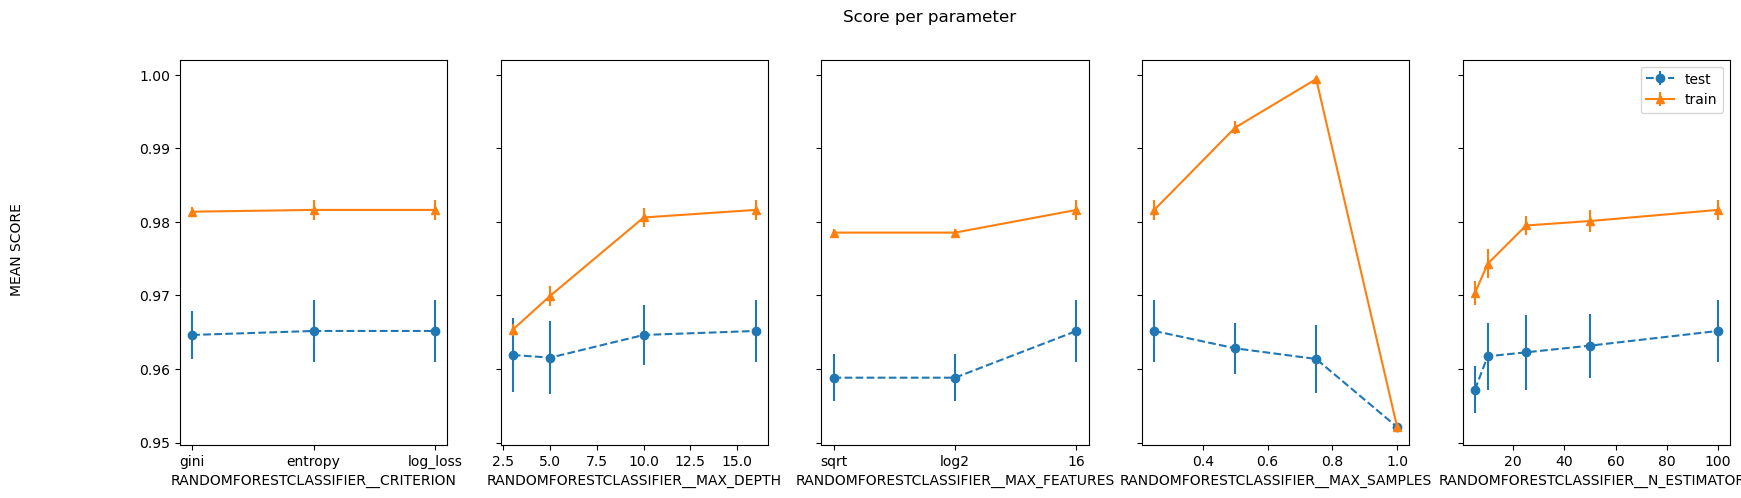

training model:GradientBoostingClassifier(random_state=3)
Fitting 4 folds for each of 1536 candidates, totalling 6144 fits
{'gradientboostingclassifier__learning_rate': 0.5, 'gradientboostingclassifier__loss': 'exponential', 'gradientboostingclassifier__max_depth': 3, 'gradientboostingclassifier__max_features': 'sqrt', 'gradientboostingclassifier__n_estimators': 50, 'gradientboostingclassifier__subsample': 0.75}
Training set score: 0.9849419448476052
Test set score: 0.9657458563535911
              precision    recall  f1-score   support

         0.0    0.97849   0.98569   0.98208      2585
         1.0    0.66667   0.56923   0.61411       130

    accuracy                        0.96575      2715
   macro avg    0.82258   0.77746   0.79809      2715
weighted avg    0.96356   0.96575   0.96446      2715

[[0.93848987 0.01362799]
 [0.02062615 0.02725599]]


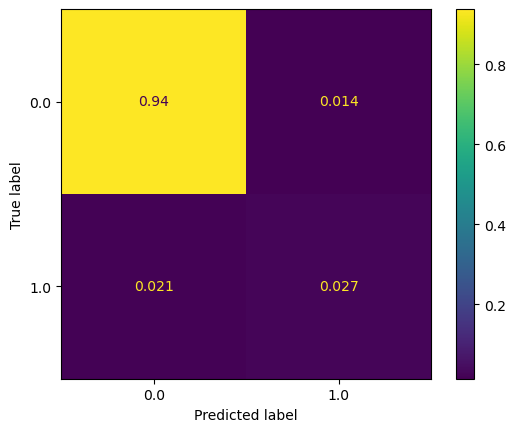

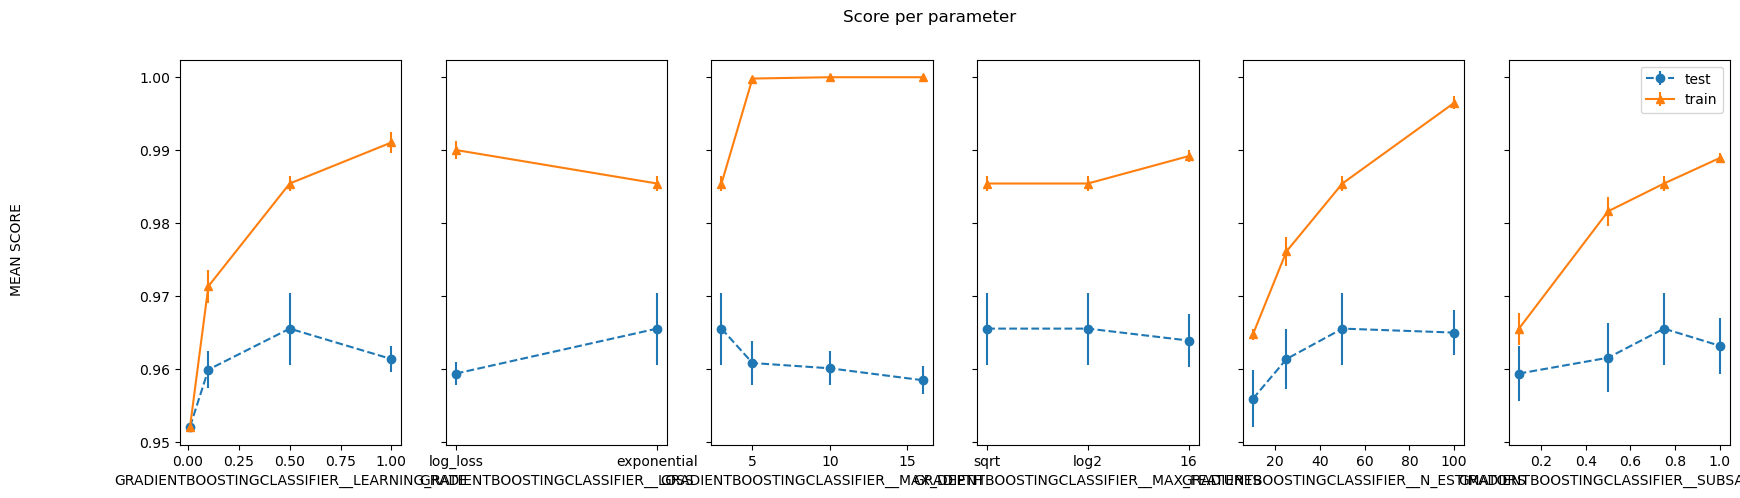

In [542]:
# create loop to test all models at once

scorer = make_scorer(accuracy_score)
#scorer = make_scorer(recall_score)

model_and_param_names = [[lr, lr_param_grid], [knn, knn_param_grid], [nb], [rf, rf_param_grid], [gb, gb_param_grid]]
for name in model_and_param_names:
    
    if name[0] == nb:
        
        print('training model:' + str(name[0]))
    
        train_and_evaluate(scaler,name[0])
    else:
        print('training model:' + str(name[0]))

        search_train_evaluate_plot(name[0], name[1], scorer)

### Model Search <a name="model"></a>

From the section above we set the best parameters for each model type and search over the best model type. 

Note that you could combine the step above with this step but increasing the number of grid search parameters multiplies the number of fits called (models to train) so splitting these tests up can help break up the computation into more manageable chunks.

In [814]:
# define best parameters for each model type

# Logistic Regression:
best_lr = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', max_iter=1000, penalty='l1', C=25)

# K-nearest Neighbors:
best_knn = KNeighborsClassifier(n_neighbors=7, weights='uniform', p=2)

# Naive Bayes:
best_nb = GaussianNB()
# There are no meaningful paramters to tune for Naive Bayes model so we willl accept the default implementation.

# Random Forest:
best_rf = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=50, criterion='gini', max_depth=5, max_features=16, max_samples=0.75, n_jobs=-1)

# Gradient Boosted Trees:
best_gb = GradientBoostingClassifier(random_state=RANDOM_STATE, n_estimators=100, loss='log_loss', learning_rate=.1, subsample=0.5, max_depth=3, max_features='sqrt')

In [949]:
# define workflow to perform grid search over model types 
#  and print the summary statistics for the best model 
#   and plot the results of the cross validation.

def model_search_train_evaluate_plot(scorer):
    
    # define model type parameters
    param_grid = [{'classifier': [best_lr]},
                  {'classifier': [best_knn]},
                  {'classifier': [best_nb]},
                  {'classifier': [best_rf]},
                  {'classifier': [best_gb]}
                 ]

    pipe = Pipeline([('scaler', scaler),
                     ('classifier', DummyClassifier())
                    ])
    
    
    
    # define parameter search
    grid_search = GridSearchCV(pipe, param_grid, cv=4, refit = True, verbose = 1, return_train_score=True, scoring=scorer, n_jobs=-1) 

    # train the model on grid search 
    grid_search.fit(X_train, y_train) 

    # print best parameters after tuning 
    print(grid_search.best_params_) 
    best_predictions = grid_search.predict(X_test) 

    # print summary of metrics for best parameters
    #model_metrics(best_predictions, grid_search)
    
    # print score for each fit
    print('mean test scores:' + str(grid_search.cv_results_['mean_test_score']))
    print('mean train scores:' + str(grid_search.cv_results_['mean_train_score']))
    x = np.arange(grid_search.cv_results_['mean_test_score'].shape[0])
    plt.plot(x, grid_search.cv_results_['mean_test_score'], 'bo-')
    plt.plot(x, grid_search.cv_results_['mean_train_score'], 'go-')

    plt.show()
    

Fitting 4 folds for each of 5 candidates, totalling 20 fits
{'classifier': GradientBoostingClassifier(max_features='sqrt', random_state=3, subsample=0.5)}
mean test scores:[0.95972424 0.9504717  0.8920537  0.96226415 0.962627  ]
mean train scores:[0.96244557 0.96244557 0.89169086 0.97254475 0.97871311]


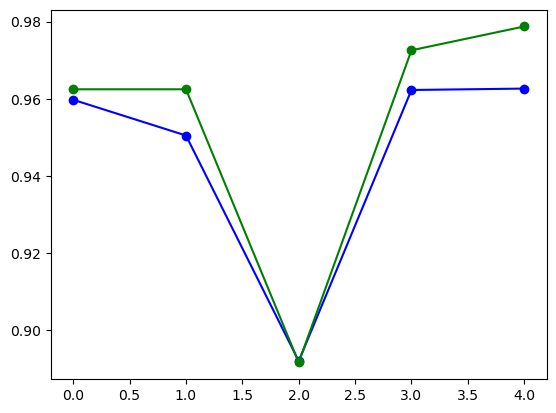

In [951]:
# choose scorer
scorer = make_scorer(accuracy_score)
#scorer = make_scorer(recall_score)

# search over model types
model_search_train_evaluate_plot(scorer)

# Selected Model Tuning <a name="final-tune"></a>

Now that we have selected our model type we can get more specific with the parameters that we want to tune. We will also revisit steps in our preprocessing phase to understand their effect on the model performance.

In [952]:
# define workflow to perform grid search over preproccesing steps 
#  and print the summary statistics for the best model 
#   and plot the results of the cross validation.

def model_search_train_evaluate_plot(scorer):
    
    # define model type parameters
    param_grid = [{'preprocessor__num__scaler': [MaxAbsScaler(),MinMaxScaler(),Normalizer(),PowerTransformer(),QuantileTransformer(),RobustScaler(),StandardScaler()]}]


    # define pipeline steps
    numeric_transformer = Pipeline(steps=[('scaler', scaler),('num_selector',SelectFpr(score_func=f_classif, alpha=0.05))])

    categorical_transformer = Pipeline(steps=[('dummy',SimpleImputer())])
    
    preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, num_features),
                    ("cat", categorical_transformer, cat_features)])
    
    pipe = Pipeline([('preprocessor', preprocessor),
                     ('classifier', best_gb)
                    ])
    
    # define parameter search
    grid_search = GridSearchCV(pipe, param_grid, cv=4, refit = True, verbose = 1, return_train_score=True, scoring=scorer, error_score='raise', n_jobs=-1) 

    # train the model on grid search 
    grid_search.fit(X_train, y_train) 

    # print best parameters after tuning 
    print(grid_search.best_params_) 
    best_predictions = grid_search.predict(X_test) 

    # print summary of metrics for best parameters
    #model_metrics(best_predictions, grid_search)
    
    # print score for each fit
    print('mean test scores:' + str(grid_search.cv_results_['mean_test_score']))
    print('mean train scores:' + str(grid_search.cv_results_['mean_train_score']))
    x = np.arange(grid_search.cv_results_['mean_test_score'].shape[0])
    plt.plot(x, grid_search.cv_results_['mean_test_score'], 'bo-')
    plt.plot(x, grid_search.cv_results_['mean_train_score'], 'go-')

    plt.show()

Fitting 4 folds for each of 7 candidates, totalling 28 fits
{'preprocessor__num__scaler': MaxAbsScaler()}
mean test scores:[0.45833333 0.45075758 0.43560606 0.45833333 0.45833333 0.44318182
 0.45075758]
mean train scores:[0.64141414 0.64520202 0.67171717 0.65025253 0.65277778 0.65025253
 0.64267677]


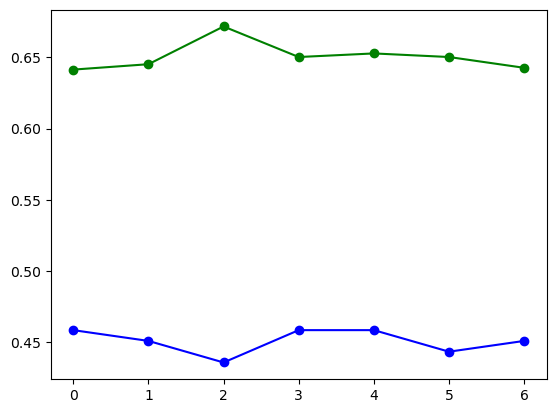

In [956]:
# choose score
#scorer = make_scorer(accuracy_score)
scorer = make_scorer(recall_score)

# search over scalers
model_search_train_evaluate_plot(scorer)

Training set score: 0.976233671988389
Test set score: 0.9627992633517496
              precision    recall  f1-score   support

         0.0    0.97224   0.98917   0.98063      2585
         1.0    0.67059   0.43846   0.53023       130

    accuracy                        0.96280      2715
   macro avg    0.82142   0.71381   0.75543      2715
weighted avg    0.95780   0.96280   0.95907      2715

[[0.94180479 0.01031308]
 [0.02688766 0.02099448]]


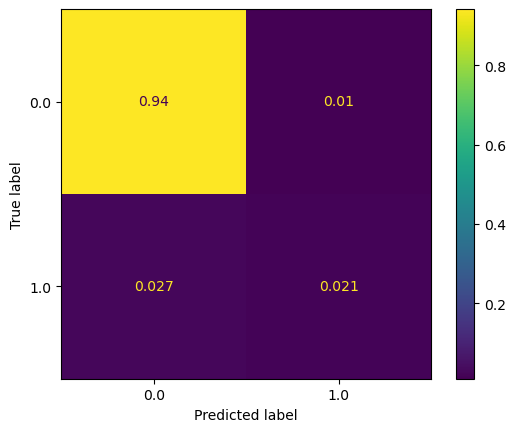

In [957]:
# Test final model
scaler = MaxAbsScaler()
model_name = best_gb

# define pipeline steps
numeric_transformer = Pipeline(steps=[('scaler', scaler),('num_selector',SelectFpr(score_func=f_classif, alpha=0.05))])

categorical_transformer = Pipeline(steps=[('dummy',SimpleImputer())])

preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, num_features),
                ("cat", categorical_transformer, cat_features)])

pipe = Pipeline([('preprocessor', preprocessor),
                 ('classifier', best_gb)
                ])

# fit data to model
pipe.fit(X_train, y_train)

# save predictions on test set
predictions = pipe.predict(X_test)

# display results and metrics
model_metrics(predictions, pipe)


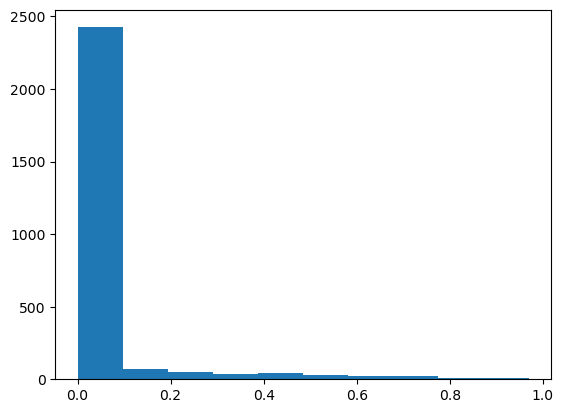

[0.00068841 0.00280438 0.00077678 ... 0.05920156 0.05323374 0.0007959 ]


In [847]:
# plot predicted probabilities on test data
probs = pipe.predict_proba(X_test)
plt.hist(probs[:,1])
plt.show()
print(probs[:,1])

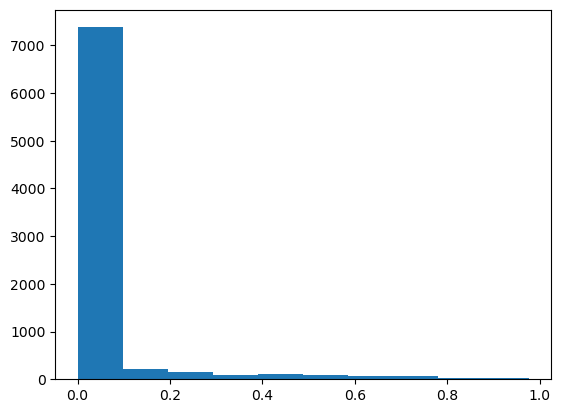

[0.43998472 0.0013921  0.00092943 ... 0.00073669 0.00071832 0.00065366]


In [848]:
# plot predicted probabilities on all data
all_probs = pipe.predict_proba(X)
plt.hist(all_probs[:,1])
plt.show()
print(all_probs[:,1])

In [849]:
# join predictions to original data frame
data['predictions'] = all_probs[:,1]

# collect instances
data_winners = data.where(data['label'] == 1)
data_losers = data.where(data['label'] == 0)

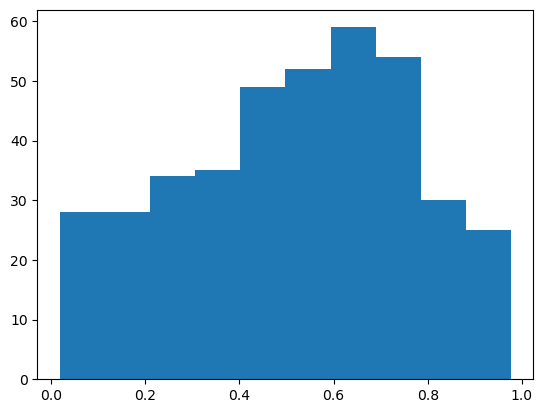

In [850]:
# plot ditribution of predictions for true winners
plt.hist(data_winners['predictions'])
plt.show()

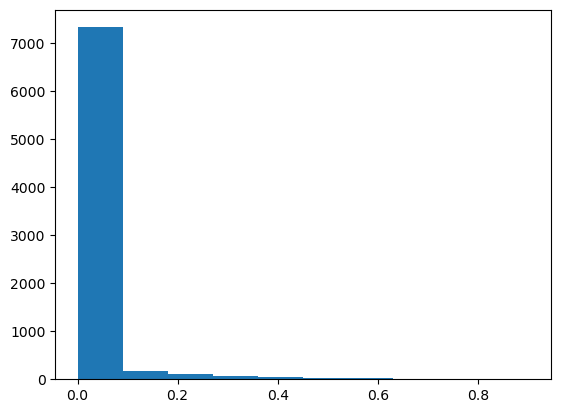

In [851]:
# plot ditribution of predictions for true losers
plt.hist(data_losers['predictions'])
plt.show()

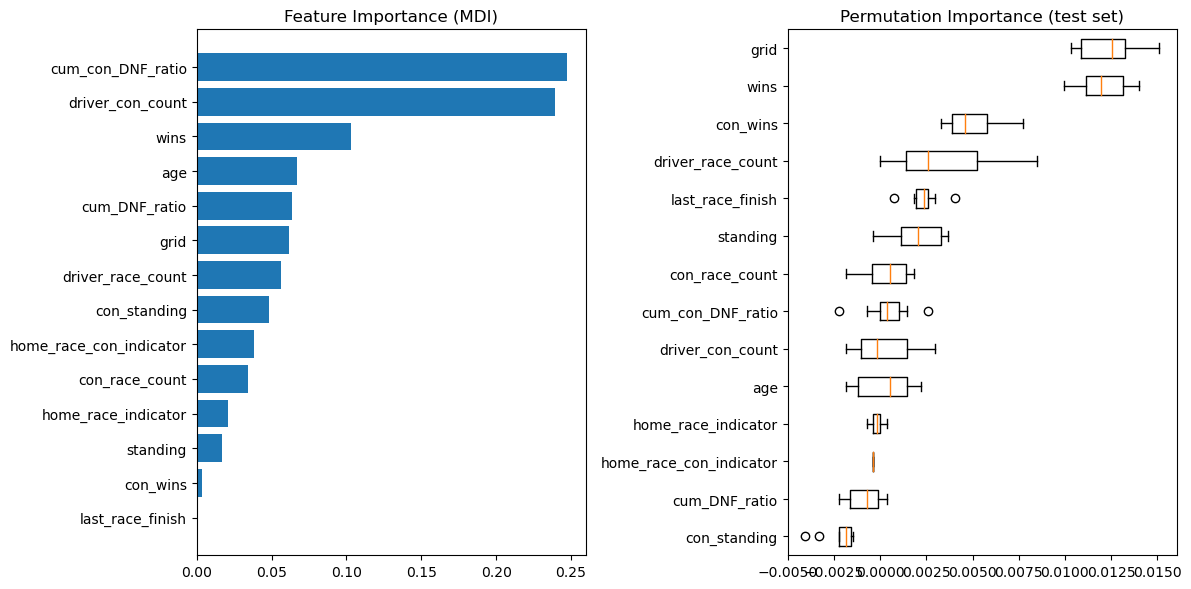

In [865]:
# feature importance ranks

from sklearn.inspection import permutation_importance

#feature_importance = model.feature_importances_
feature_importance = pipe.named_steps['classifier'].feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(feature_list)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    pipe, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_list)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

In [867]:
#!pip install shap

  Obtaining dependency information for shap from https://files.pythonhosted.org/packages/fb/99/2364cc073662517335383f68a10549c6b75486b99f0d671179e4dd8252d6/shap-0.43.0-cp311-cp311-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 445.4/445.4 kB 5.7 MB/s eta 0:00:00a 0:00:01


In [868]:
import shap

In [940]:
X_test_sample = X_test.sample(100)
#shap.decision_plot(explainer.expected_value, shap_values, features_display) #X_test.columns)

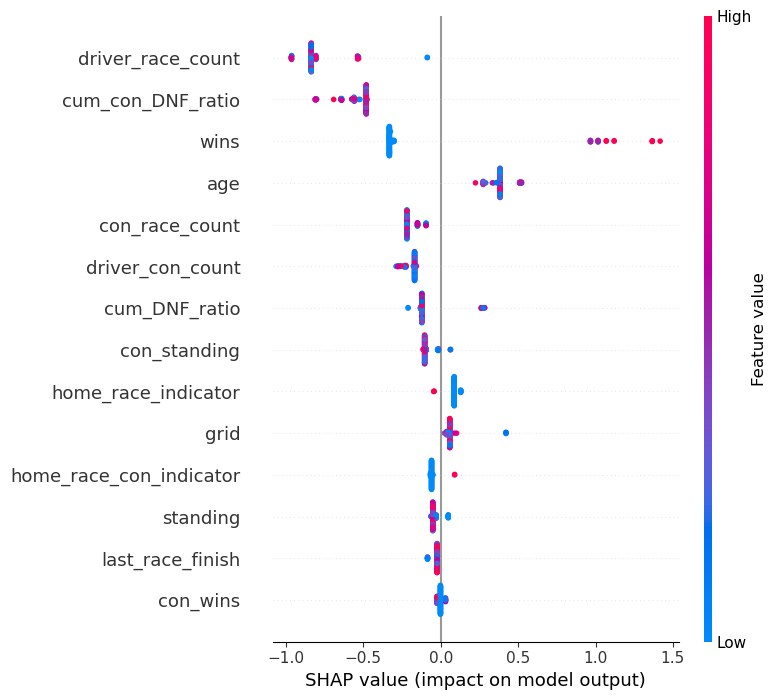

In [942]:
explainer = shap.Explainer(pipe.named_steps['classifier'])
shap_values = explainer.shap_values(X_test_sample)

shap.summary_plot(shap_values, X_test_sample)

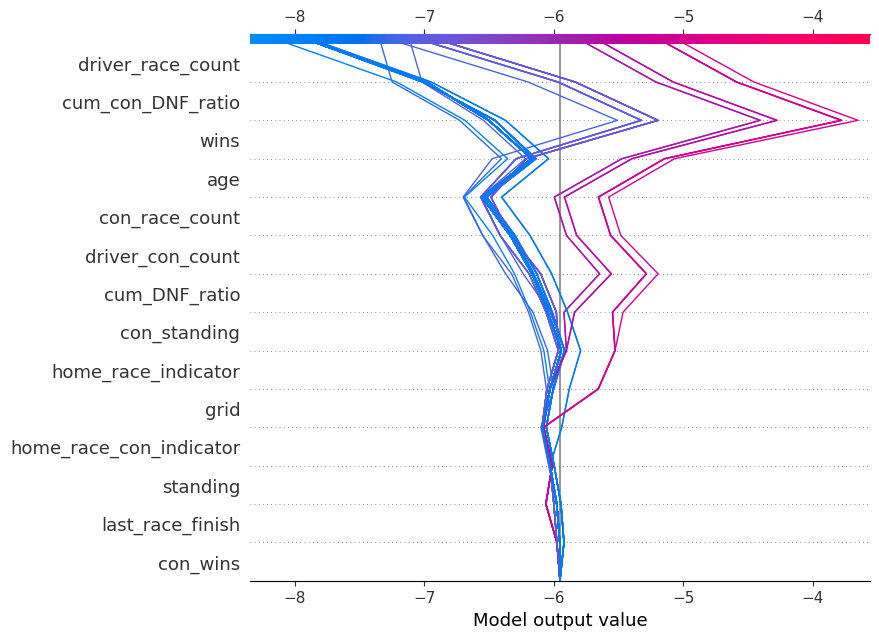

In [944]:
shap.decision_plot(explainer.expected_value, shap_values, X_test_sample.columns)